## Installing Dependencies

In [3]:
!pip install -qU "numpy<2.0" "opencv-python-headless==4.10.*"
!pip install -qU ultralytics --no-deps
import ultralytics
ultralytics.checks()

Ultralytics 8.3.234 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6563.3/8062.4 GB disk)


## Importing

In [4]:
import json
import os
import shutil
import numpy as np
from tqdm.notebook import tqdm
import yaml

DATASET_BASE = '/kaggle/input/solesensei_bdd100k' 

INPUT_ROOT = os.path.join(DATASET_BASE, 'bdd100k/bdd100k')

TRAIN_JSON = os.path.join(DATASET_BASE, 'bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_train.json')
VAL_JSON = os.path.join(DATASET_BASE, 'bdd100k_labels_release/bdd100k/labels/bdd100k_labels_images_val.json')

OUTPUT_DIR = '/kaggle/working/datasets/bdd100k'

IMG_WIDTH = 1280
IMG_HEIGHT = 720

if os.path.exists(INPUT_ROOT):
    print(f"Found Image Directory: {INPUT_ROOT}")
else:
    print(f"Error: Could not find {INPUT_ROOT}")
    print("Available folders in /kaggle/input/:", os.listdir('/kaggle/input'))
    if os.path.exists(DATASET_BASE):
        print(f"Contents of {DATASET_BASE}:", os.listdir(DATASET_BASE))

print("Paths set. Ready to proceed.")

Found Image Directory: /kaggle/input/solesensei_bdd100k/bdd100k/bdd100k
Paths set. Ready to proceed.


## Defining Classes

In [5]:
CLASSES = [
    "pedestrian", "rider", "car", "truck", "bus", 
    "train", "motorcycle", "bicycle", "traffic light", "traffic sign"
]

class_mapping = {name: i for i, name in enumerate(CLASSES)}

print(f"Classes defined: {class_mapping}")

Classes defined: {'pedestrian': 0, 'rider': 1, 'car': 2, 'truck': 3, 'bus': 4, 'train': 5, 'motorcycle': 6, 'bicycle': 7, 'traffic light': 8, 'traffic sign': 9}


## Preprocessing of labels

In [6]:
def convert_bdd_to_yolo(json_path, output_labels_dir, split_name):
    print(f"Loading {split_name} JSON...")
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    print(f"Converting {len(data)} images for {split_name}...")
    
    os.makedirs(output_labels_dir, exist_ok=True)
    
    for entry in tqdm(data, desc=f"Processing {split_name}"):
        image_name = entry['name']
        txt_name = image_name.replace('.jpg', '.txt')
        txt_path = os.path.join(output_labels_dir, txt_name)
        
        yolo_lines = []
        
        for label in entry.get('labels', []):
            category = label['category']
            
            if category not in class_mapping:
                continue
                
            class_id = class_mapping[category]
            
            if 'box2d' in label:
                box = label['box2d']
                x1, y1, x2, y2 = box['x1'], box['y1'], box['x2'], box['y2']
                
                dw = 1.0 / IMG_WIDTH
                dh = 1.0 / IMG_HEIGHT
                
                w = x2 - x1
                h = y2 - y1
                x_center = x1 + (w / 2)
                y_center = y1 + (h / 2)

                x_center *= dw
                w *= dw
                y_center *= dh
                h *= dh
                
                yolo_lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}")
        
        if yolo_lines:
            with open(txt_path, 'w') as f_out:
                f_out.write('\n'.join(yolo_lines))

print("Conversion function defined.")

Conversion function defined.


In [7]:
dirs = {
    'train': {
        'images_in': os.path.join(INPUT_ROOT, 'images/100k/train'),
        'images_out': os.path.join(OUTPUT_DIR, 'images/train'),
        'labels_out': os.path.join(OUTPUT_DIR, 'labels/train'),
        'json': TRAIN_JSON
    },
    'val': {
        'images_in': os.path.join(INPUT_ROOT, 'images/100k/val'),
        'images_out': os.path.join(OUTPUT_DIR, 'images/val'),
        'labels_out': os.path.join(OUTPUT_DIR, 'labels/val'),
        'json': VAL_JSON
    }
}

for split, paths in dirs.items():
    convert_bdd_to_yolo(paths['json'], paths['labels_out'], split)
    
    print(f"Symlinking {split} images...")
    os.makedirs(paths['images_out'], exist_ok=True)
    
    labeled_files = {f.replace('.txt', '.jpg') for f in os.listdir(paths['labels_out'])}
    
    count = 0
    for img_name in tqdm(os.listdir(paths['images_in']), desc=f"Linking {split} images"):
        if img_name in labeled_files:
            src = os.path.join(paths['images_in'], img_name)
            dst = os.path.join(paths['images_out'], img_name)
            if not os.path.exists(dst):
                os.symlink(src, dst)
            count += 1
            
    print(f"Linked {count} images for {split}.")

Loading train JSON...
Converting 69863 images for train...


Processing train:   0%|          | 0/69863 [00:00<?, ?it/s]

Symlinking train images...


Linking train images:   0%|          | 0/1160 [00:00<?, ?it/s]

Linked 1153 images for train.
Loading val JSON...
Converting 10000 images for val...


Processing val:   0%|          | 0/10000 [00:00<?, ?it/s]

Symlinking val images...


Linking val images:   0%|          | 0/10000 [00:00<?, ?it/s]

Linked 9999 images for val.


## Creating YAML

In [8]:
yaml_content = {
    'path': OUTPUT_DIR,
    'train': 'images/train',
    'val': 'images/val',
    'names': {i: name for i, name in enumerate(CLASSES)}
}

yaml_path = '/kaggle/working/bdd100k_atcc.yaml'

with open(yaml_path, 'w') as f:
    yaml.dump(yaml_content, f, sort_keys=False)

print(f"YAML config created at {yaml_path}")
print(yaml_content)

YAML config created at /kaggle/working/bdd100k_atcc.yaml
{'path': '/kaggle/working/datasets/bdd100k', 'train': 'images/train', 'val': 'images/val', 'names': {0: 'pedestrian', 1: 'rider', 2: 'car', 3: 'truck', 4: 'bus', 5: 'train', 6: 'motorcycle', 7: 'bicycle', 8: 'traffic light', 9: 'traffic sign'}}


## EDA

In [9]:
import os
import glob
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

CLASSES = [
    "pedestrian", "rider", "car", "truck", "bus", 
    "train", "motorcycle", "bicycle", "traffic light", "traffic sign"
]
class_mapping = {i: name for i, name in enumerate(CLASSES)}
OUTPUT_DIR = '/kaggle/working/datasets/bdd100k' 

train_labels_dir = os.path.join(OUTPUT_DIR, 'labels/train')
val_labels_dir = os.path.join(OUTPUT_DIR, 'labels/val')

def count_annotations(labels_dir, split_name):
    counts = {name: 0 for name in CLASSES}
    image_count = 0
    
    label_files = glob.glob(os.path.join(labels_dir, '*.txt'))
    
    for file_path in tqdm(label_files, desc=f"Counting {split_name} annotations"):
        image_count += 1
        with open(file_path, 'r') as f:
            for line in f:
                try:
                    class_id = int(line.split()[0])
                    class_name = class_mapping.get(class_id)
                    if class_name:
                        counts[class_name] += 1
                except (ValueError, IndexError):
                    continue
    
    return counts, image_count

train_counts, train_image_count = count_annotations(train_labels_dir, 'Train')
val_counts, val_image_count = count_annotations(val_labels_dir, 'Validation')

df_train = pd.DataFrame(list(train_counts.items()), columns=['Class', 'Train Annotations'])
df_val = pd.DataFrame(list(val_counts.items()), columns=['Class', 'Validation Annotations'])

df_merged = pd.merge(df_train, df_val, on='Class')
df_merged['Total Annotations'] = df_merged['Train Annotations'] + df_merged['Validation Annotations']
df_merged_long = pd.melt(df_merged, id_vars='Class', value_vars=['Train Annotations', 'Validation Annotations'],
                         var_name='Split', value_name='Annotation Count')

print("\n--- Summary Data ---")
print(f"Total Train Images: {train_image_count}")
print(f"Total Validation Images: {val_image_count}")
print(f"Total Annotations: {df_merged['Total Annotations'].sum()}")
print("\nAnnotation Counts per Class and Split:\n", df_merged)

Counting Train annotations:   0%|          | 0/69849 [00:00<?, ?it/s]

Counting Validation annotations:   0%|          | 0/9999 [00:00<?, ?it/s]


--- Summary Data ---
Total Train Images: 69849
Total Validation Images: 9999
Total Annotations: 1356115

Annotation Counts per Class and Split:
            Class  Train Annotations  Validation Annotations  Total Annotations
0     pedestrian                  0                       0                  0
1          rider               4517                     649               5166
2            car             713211                  102506             815717
3          truck              29971                    4245              34216
4            bus              11672                    1597              13269
5          train                136                      15                151
6     motorcycle                  0                       0                  0
7        bicycle                  0                       0                  0
8  traffic light             186117                   26885             213002
9   traffic sign             239686                   34908     

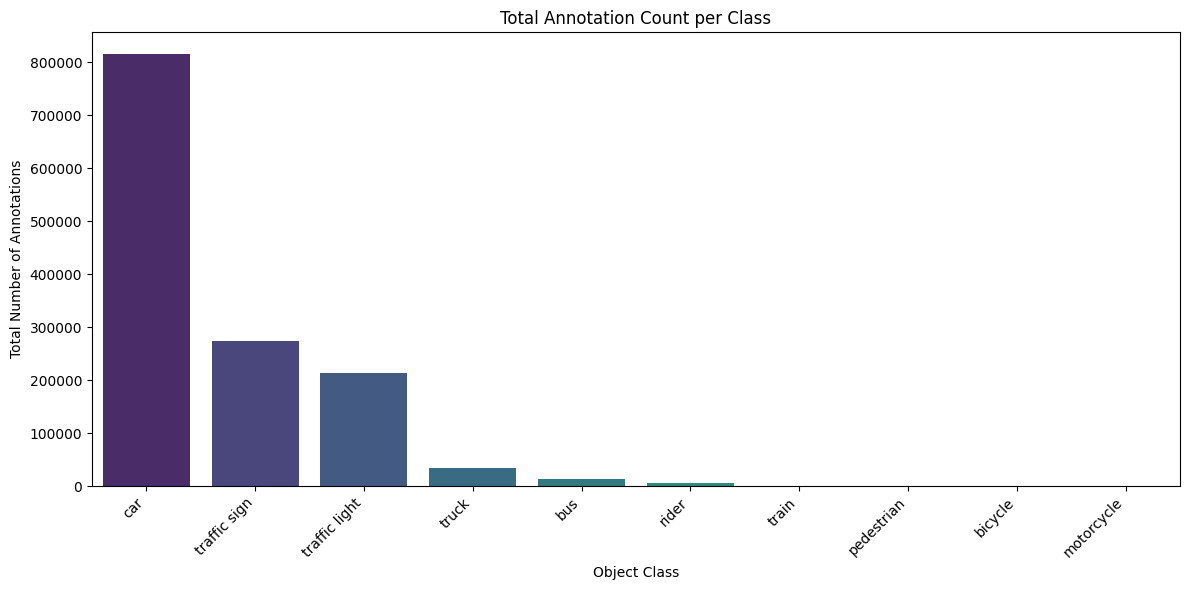

In [10]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Class', y='Total Annotations', data=df_merged.sort_values(by='Total Annotations', ascending=False), palette='viridis')
plt.title('Total Annotation Count per Class')
plt.xlabel('Object Class')
plt.ylabel('Total Number of Annotations')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

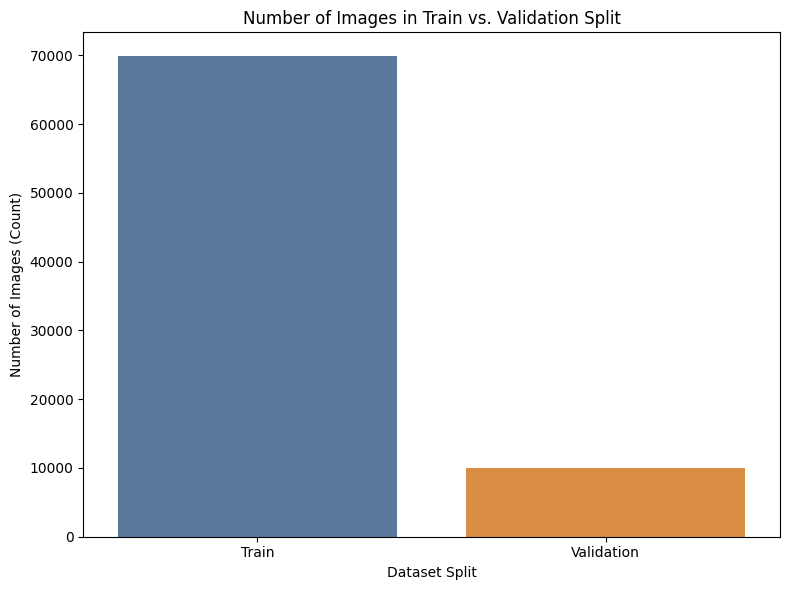

In [11]:
image_data = pd.DataFrame({
    'Split': ['Train', 'Validation'],
    'Image Count': [train_image_count, val_image_count]
})

plt.figure(figsize=(8, 6))
sns.barplot(x='Split', y='Image Count', data=image_data, palette=['#4e79a7', '#f28e2b'])
plt.title('Number of Images in Train vs. Validation Split')
plt.xlabel('Dataset Split')
plt.ylabel('Number of Images (Count)')
plt.tight_layout()
plt.show()

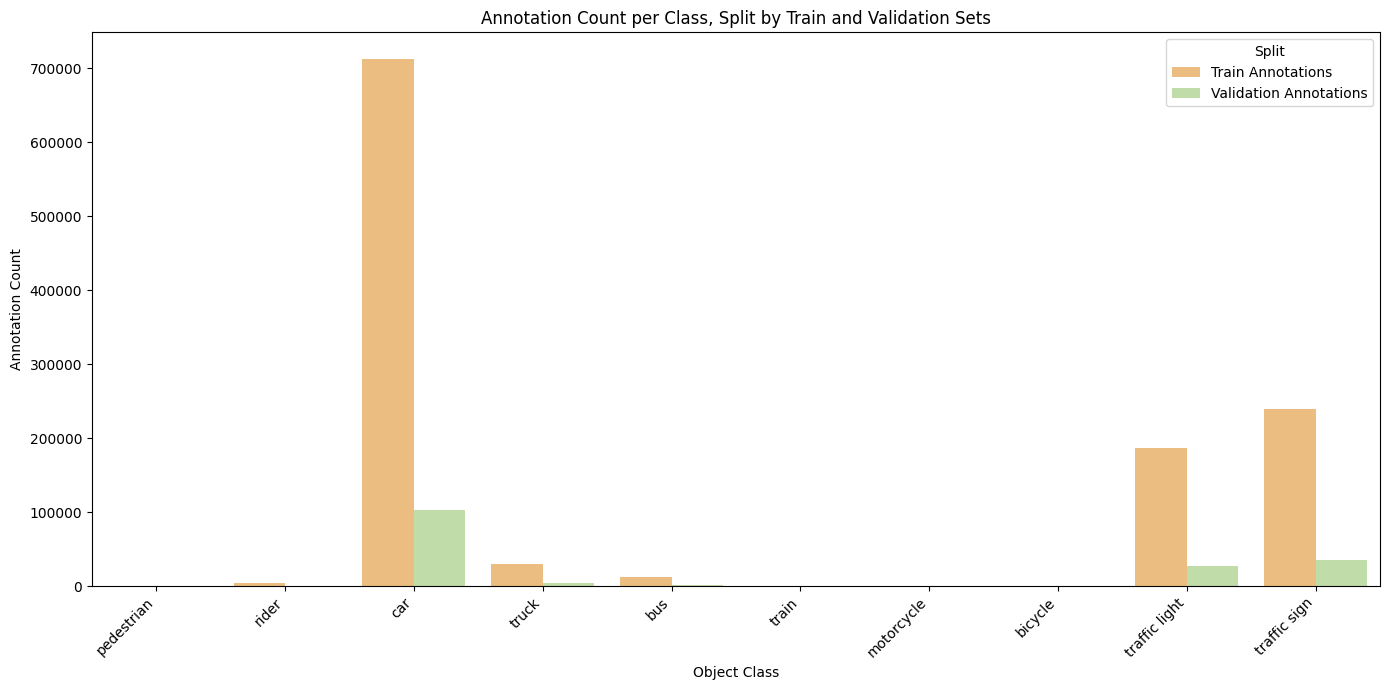

In [12]:
plt.figure(figsize=(14, 7))
sns.barplot(x='Class', y='Annotation Count', hue='Split', data=df_merged_long, palette='Spectral')
plt.title('Annotation Count per Class, Split by Train and Validation Sets')
plt.xlabel('Object Class')
plt.ylabel('Annotation Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Split')
plt.tight_layout()
plt.show()

## Traning

In [9]:
from ultralytics import YOLO

model = YOLO('yolov8s.pt') 

results = model.train(
    data='/kaggle/working/bdd100k_atcc.yaml',
    epochs=50,
    imgsz=640,
    batch=64,
    name='bdd_atcc_run',
    project='/kaggle/working/runs'
)

print("Training started...")

Ultralytics 8.3.233 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/bdd100k_atcc.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=bdd_atcc_run2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspectiv

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       9999     170805      0.448      0.325      0.328       0.18
                 rider        515        649       0.37      0.159      0.145     0.0572
                   car       9879     102506       0.71      0.625      0.674      0.405
                 truck       2689       4245      0.473      0.355      0.331      0.221
                   bus       1242       1597      0.422      0.349      0.324      0.236
                 train         14         15          0          0          0          0
         traffic light       5653      26885      0.582      0.374      0.391      0.129
          traffic sign       8221      34908      0.583      0.412      0.429      0.211
Speed: 0.1ms preprocess, 2.7ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /kaggle/working/runs/bdd_atcc_run2
Training started...


## Vizualization


image 1/1 /kaggle/working/datasets/bdd100k/images/val/ca3736db-ab6db00c.jpg: 384x640 19 cars, 3 traffic lights, 1 traffic sign, 8.9ms
Speed: 1.6ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
Results saved to /kaggle/working/runs/detect/predict4
Prediction saved. Displaying...


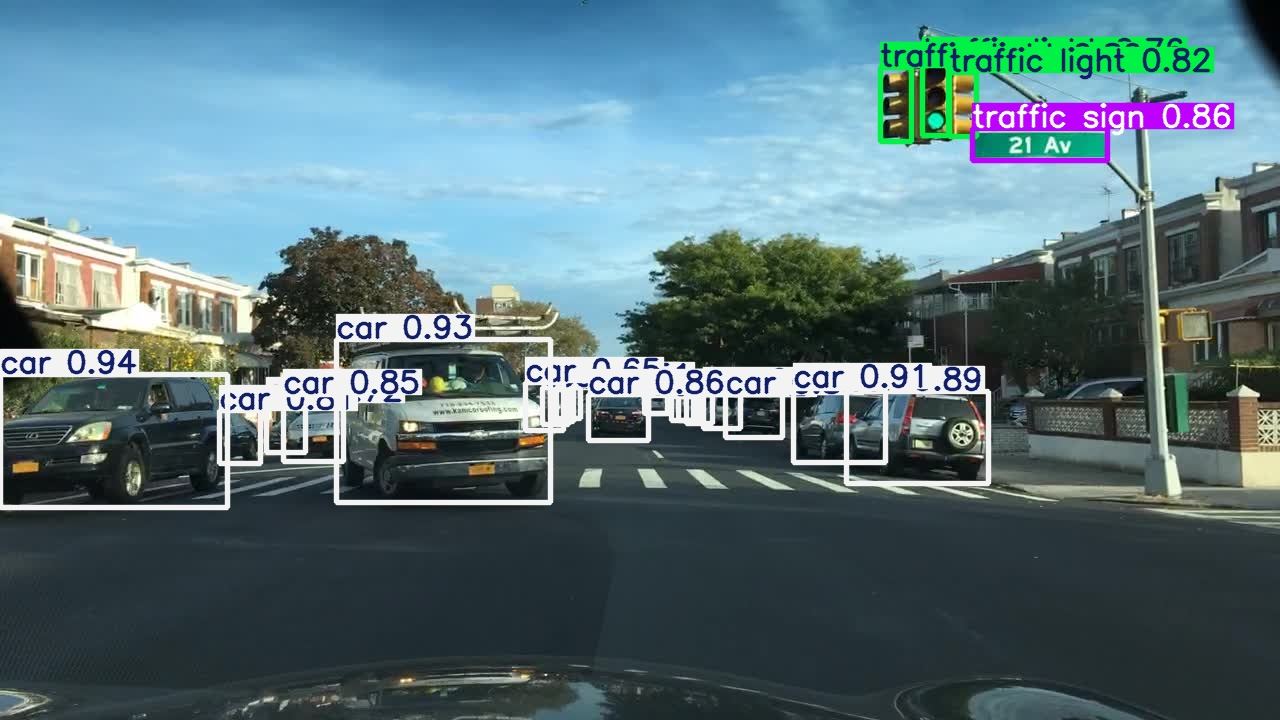

In [13]:
import glob
from IPython.display import Image, display

run_dir = glob.glob('/kaggle/working/runs/bdd_atcc_run*')[-1]
best_model_path = os.path.join(run_dir, 'weights/best.pt')

best_model = YOLO(best_model_path)

val_img_path = glob.glob(os.path.join(OUTPUT_DIR, 'images/val/*.jpg'))[110]

results = best_model.predict(val_img_path, save=True)

print("Prediction saved. Displaying...")
display(Image(filename=results[0].save_dir + '/' + os.path.basename(val_img_path)))